In [1]:
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import cv2,math,glob,random
import os
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from google.colab import drive
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import precision_recall_fscore_support as score
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Preprocessing

In [5]:
%%capture
!unzip /content/gdrive/MyDrive/Head_Pose/AFLW2000-3D.zip

In [4]:
images_paths = sorted(glob.glob('/content/AFLW2000/*.jpg'))
images_mat_paths = sorted(glob.glob('/content/AFLW2000/*.mat'))

In [5]:
def extract_poses(img, face_mesh, mat=None):

    result = face_mesh.process(img)
    face_features = []

    if mat:
      pose_angles = mat['Pose_Para'][0][:3]
      face_features.extend(pose_angles)
      
    if result.multi_face_landmarks != None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):

              face_features.append(lm.x* img.shape[1])
              face_features.append(lm.y* img.shape[0])
        
    return face_features

In [6]:
def face_mesh():

  face_mesh = mediapipe.solutions.face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5)
  
  return face_mesh

In [7]:
def dataframe(face_mesh,images_paths,images_mat_paths):
  poses = []

  if len(images_paths)<=32:  # one image so 32 character
    img = cv2.imread(images_paths)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mat = sio.loadmat(images_mat_paths)
    face_features = extract_poses(img, face_mesh, mat)
    poses.append(face_features)
  else:
    for img_idx, img_path in enumerate(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mat = sio.loadmat(images_mat_paths[img_idx])
        face_features = extract_poses(img, face_mesh, mat)
        poses.append(face_features)

  poses_df = pd.DataFrame(poses)

  # drop null 
  poses_df.dropna(inplace=True)
  poses_df.reset_index(drop=True, inplace=True)

  return poses_df

In [8]:
def normalize(poses_df):
  # nose = 1, left_eye = 33, left_mouth = 61, chin = 199, right_eye = 263, right_mouth = 291
    normalized_df = poses_df.copy()

    diff = np.linalg.norm(np.array(poses_df[[529, 530]]) - np.array(poses_df[[401, 402]]) , axis=1).reshape(-1, 1)

    for feature in poses_df:
        if feature in [0, 1, 2]:
            continue
        elif feature % 2 == 0:
            normalized_df[feature] = poses_df[feature] - poses_df[6]
        else:
            normalized_df[feature] = poses_df[feature] - poses_df[5]

    for idx, row in normalized_df.iloc[:,3:].iterrows():
      row /= diff[idx]
    
    return normalized_df

In [9]:
def normalize2(poses_df): # dataframe without angles columns
  
    normalized_df = poses_df.copy()

    diff = np.linalg.norm(np.array(poses_df[[526, 527]]) - np.array(poses_df[[398, 399]]) , axis=1).reshape(-1, 1)

    for feature in poses_df:

        if feature % 2 == 0:
            normalized_df[feature] = poses_df[feature] - poses_df[2]
        else:
            normalized_df[feature] = poses_df[feature] - poses_df[3]

    for idx, row in normalized_df.iterrows():
      row /= diff[idx]
    
    return normalized_df

In [10]:
def data(images_paths,images_mat_paths,csv=False):
  df = dataframe(face_mesh(),images_paths,images_mat_paths)
  if csv:
    df = normalize(df)
    df.to_csv('./head_pose.csv', index=False)

  return df

# Model Training

In [11]:
data(images_paths,images_mat_paths,csv=True)

,0,1,2,3,4,5,6,7,8,9,...,949,950,951,952,953,954,955,956,957,958
0,-0.399231,0.018227,0.085676,-0.003508,0.133169,0.0,0.0,0.006790,0.014070,-0.023073,...,0.359746,-0.474651,0.426925,-0.469279,0.362824,-0.539088,0.292673,-0.480431,0.356756,-0.409376
1,0.470065,1.189533,0.300959,0.127718,0.326350,0.0,0.0,0.118680,0.093524,0.075895,...,0.534177,-0.269137,0.575724,-0.266382,0.533595,-0.321025,0.499089,-0.271783,0.536838,-0.217036
2,-0.184650,0.881137,-0.236852,0.014698,0.101657,0.0,0.0,-0.006474,0.035846,-0.048826,...,0.313410,-0.404152,0.361413,-0.402759,0.317296,-0.448781,0.264077,-0.405740,0.308943,-0.359095
3,-0.175379,0.299208,-0.373374,0.121735,0.109582,0.0,0.0,0.060931,0.014704,-0.076628,...,0.280401,-0.551668,0.335210,-0.569388,0.266563,-0.598845,0.225847,-0.533977,0.293949,-0.503706
4,-0.026812,0.011965,-0.220662,0.051186,0.216999,0.0,0.0,0.012896,0.049374,-0.082896,...,0.207097,-0.434128,0.262769,-0.447046,0.196573,-0.481594,0.151996,-0.421723,0.218301,-0.386190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,-0.173351,-0.060273,0.000774,-0.027414,0.155411,0.0,0.0,-0.014013,0.041966,-0.049891,...,0.280797,-0.387443,0.336421,-0.384677,0.282315,-0.436123,0.223675,-0.390721,0.278701,-0.338723
1839,-0.306358,-0.283822,0.038554,-0.066982,0.181183,0.0,0.0,-0.038033,0.034484,-0.070306,...,0.160799,-0.459683,0.224862,-0.460004,0.162436,-0.513640,0.096693,-0.459087,0.160001,-0.406050
1840,-0.367547,-0.429723,0.122791,-0.066584,0.161868,0.0,0.0,-0.046627,0.031380,-0.060787,...,0.119163,-0.456997,0.175447,-0.454945,0.124289,-0.508591,0.063523,-0.458488,0.114591,-0.405124
1841,-0.197102,-0.070430,0.105118,-0.026723,0.156537,0.0,0.0,-0.006567,0.033650,-0.030255,...,0.330394,-0.415316,0.391741,-0.409113,0.335552,-0.466766,0.269284,-0.421619,0.325328,-0.363012


In [12]:
df = pd.read_csv('./head_pose.csv')

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_df.drop(['0','1','2'], axis=1)
y_train = train_df[['0','1','2']]

X_val = val_df.drop(['0','1','2'], axis=1)
y_val = val_df[['0','1','2']]

In [13]:
def model_eval(model):

  multi_reg = MultiOutputRegressor(model).fit(X_train, y_train)

  print("score: ", multi_reg.score(X_val, y_val))
  y_train_pred= multi_reg.predict(X_train)
  y_val_pred= multi_reg.predict(X_val)
  print("train error: ", np.sqrt(mean_squared_error(y_train,y_train_pred)))
  print("valid error: ", np.sqrt(mean_squared_error(y_val,y_val_pred)))
  return multi_reg

In [14]:
# gsc = GridSearchCV(
#             estimator=XGBRegressor(),
#             param_grid={"learning_rate": (0.05, 0.10, 0.15),
#                         "max_depth": [ 3, 4, 5, 6, 8],
#                         "min_child_weight": [ 1, 3, 5, 7],
#                         "gamma":[ 0.0, 0.1, 0.2],
#                         "colsample_bytree":[ 0.3, 0.4],},
#             cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# grid_result = MultiOutputRegressor(gsc).fit(X_train, y_train)

# best_params = grid_result.estimators_[0].best_params_  # for the first y_target estimator
# print('best parameters: ',best_params)

In [15]:
model_eval(XGBRegressor(colsample_bytree= 0.4, gamma= 0.0, learning_rate= 0.1, max_depth=3, min_child_weight= 7,silent=True))

score:  -0.8667000439617404
train error:  0.16527217571228153
valid error:  0.41952976915869006


MultiOutputRegressor(estimator=XGBRegressor(colsample_bytree=0.4, gamma=0.0,
                                            min_child_weight=7, silent=True))

In [16]:
model_eval(SVR(C=100))

score:  0.7537881242083134
train error:  0.4073016450179902
valid error:  0.15771920811978388


MultiOutputRegressor(estimator=SVR(C=100))

In [17]:
best_reg = model_eval(SVR(kernel='rbf',C=3,degree=3,epsilon=0.1,tol=0.00001))  # best model score and rmse

score:  0.8543579780088818
train error:  0.474013258321421
valid error:  0.12275089237950804


In [18]:
model_eval(RandomForestRegressor(n_estimators=6,max_depth=8))

score:  -0.10515213172412681
train error:  0.18978352986631367
valid error:  0.3269363641958098


MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=8,
                                                     n_estimators=6))

In [19]:
model_eval(Ridge())

score:  0.5551311438877006
train error:  0.44840151928600974
valid error:  0.20720618035341068


MultiOutputRegressor(estimator=Ridge())

In [20]:
model_eval(LinearRegression())

score:  -0.4822698464610311
train error:  0.08641615539630702
valid error:  0.364243127831057


MultiOutputRegressor(estimator=LinearRegression())

In [21]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

# Test on Image

In [34]:
img = data(images_paths[6],images_mat_paths[6],csv=False)
img

,0,1,2,3,4,5,6,7,8,9,...,949,950,951,952,953,954,955,956,957,958
0,0.057119,0.110732,-0.043283,222.432093,300.677669,218.106616,264.955768,219.886127,275.121662,211.517005,...,266.515446,213.944712,274.8234,213.841635,266.391259,206.977701,258.270818,214.026654,266.662887,220.904978


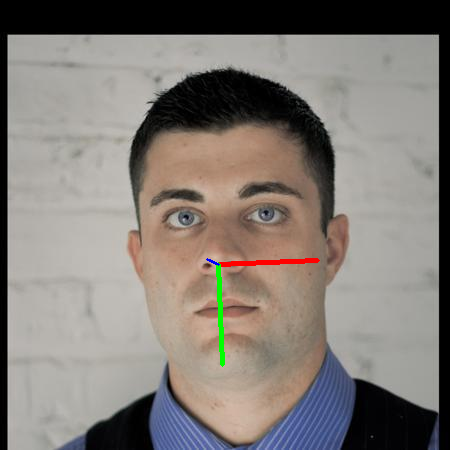

In [35]:
image = cv2.imread(images_paths[6])
cv2_imshow(draw_axis(image,float(img[0][0]),float(img[1][0]),float(img[2][0]),float(img[5][0]),float(img[6][0])))

In [36]:
pred = best_reg.predict(img.drop([0,1,2], axis=1))
print(pred)

[[-0.03855501 -0.05728733 -0.20108722]]


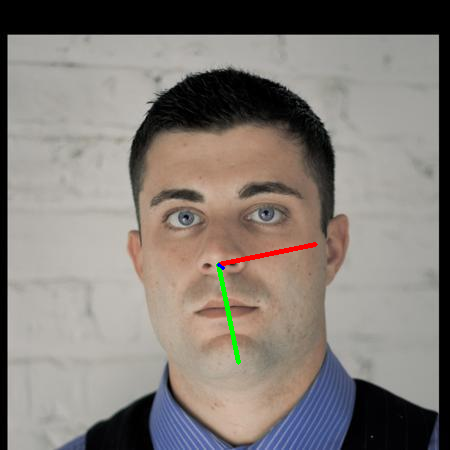

In [37]:
image1 = cv2.imread(images_paths[6])
cv2_imshow(draw_axis(image1,float(pred[0][0]),float(pred[0][1]),float(pred[0][2]),float(img[5][0]),float(img[6][0])))

# Test on Video

In [26]:
cap = cv2.VideoCapture("/content/vid.mp4")
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video_name = 'output.mp4'
video = cv2.VideoWriter(video_name, fourcc, 20, (width,height))
i=0
while (cap.isOpened() and i<280):

  # reading from frame
  success, frame = cap.read()

  if success is not True:
    break

  # extraxt landmarks from image
  poses = []
  img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  pose = extract_poses(img, face_mesh())
  poses.append(pose)
  x_test = pd.DataFrame(poses)
  
  if len(x_test)!=0:
   
    # normalize data
    print(x_test)
    x_test_norm = normalize2(x_test)

    # predict angles

    pred_v = best_reg.predict(x_test_norm)

    # draw axis 
    
    frame = draw_axis(frame,float(pred_v[0][0]),float(pred_v[0][1]),float(pred_v[0][2]),float(x_test[3][0]),float(x_test[4][0]))
    # cv2.circle(frame, center=[int(pose[0]* frame.shape[1]), int(pose[1]* frame.shape[0])], radius=2, color=(0, 255, 0),thickness=2)
    # cv2.imshow(frame)

    # write frame to video
    video.write(frame)
  i+=1

# Release all space and windows once done
cv2.destroyAllWindows()
video.release()

          0           1           2           3           4           5    \
0  852.892532  415.379076  882.589493  366.672263  860.661926  378.913221   

          6           7           8           9    ...         946       947  \
0  870.702744  325.094697  887.155914  354.459693  ...  887.907944  304.7719   

          948        949         950         951        952         953  \
0  896.111755  307.19902  889.816589  295.821176  879.41391  302.239294   

          954         955  
0  885.840225  313.855448  

[1 rows x 956 columns]
          0           1           2           3           4           5    \
0  853.468399  415.207286  879.934692  365.946822  859.024506  378.731775   

          6           7           8           9    ...         946  \
0  868.694305  325.345409  884.429626  353.852506  ...  886.189651   

          947         948         949         950         951         952  \
0  305.349648  894.368134  307.411044  886.863174  297.007055  877.693634   

  